# MazeDrone with TF Agents - 16 Sanity Check

In [1]:
from __future__ import absolute_import, division, print_function

import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'


import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

from resources import build_agent, TrainingSession
import pandas as pd
import gc




min_combination = 1
min_run = 1
max_run = 1


num_iterations = 5_000 # @param {type:"integer"}

initial_collect_steps = 64  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = False  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

# Agent fully connected layer params 
fc_layer_params = (200,) 

# File's name
description = "17"
maze_size = 3

rewards = []
rewards.append({
    'destroyed': -10.,
    'stuck': - 5.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -11.,
    'reached': 10.,
    'standard': -1.
})
rewards.append({
    'destroyed': -10.,
    'stuck': -15.,
    'reached': 10.,
    'standard': -1.
})

sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

train_py_env = suite_gym.load(env_name)
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)





# CREATING/RESETING THE AGENT
agent = build_agent(fc_layer_params, env, learning_rate, train_env)
agent.initialize()


2024-10-25 17:18:29.234925: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 17:18:29.240156: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-25 17:18:29.324307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 17:18:30.733903: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Training

In [2]:
for combination in range(min_combination-1, min_combination):

    for run in range(min_run-1, max_run):
        print('Combination', combination + 1, ' | Run', run + 1)

        agent._optimizer.learning_rate = learning_rate
        print(agent.train_step_counter)


        # GENERATE TRAINING SESSION
        session = TrainingSession(description, maze_size, env_name, rewards[combination], agent, collect_steps_per_iteration, 
                                num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes)
        
        # TRAINING
        step_log, returns, finished, crashed, stucked, steped, log_loss, _, _ = session.train(without_wall_training=True)

        # LOGGING
        df_log = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': log_loss})
        #df_log.to_csv(f"logs/02-stuck-improving/{description}_comb-{combination+1}-run-{run+1}.csv", index=None, header=True)




Combination 1  | Run 1
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0>
Rewards Updated: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Mode set: 1
Mode set: 1
Maze site set: 3x3
Maze site set: 3x3
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Rewards: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1000
step = 2000
step = 3000
step = 4000
step = 5000
learning_rate inside: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.0>


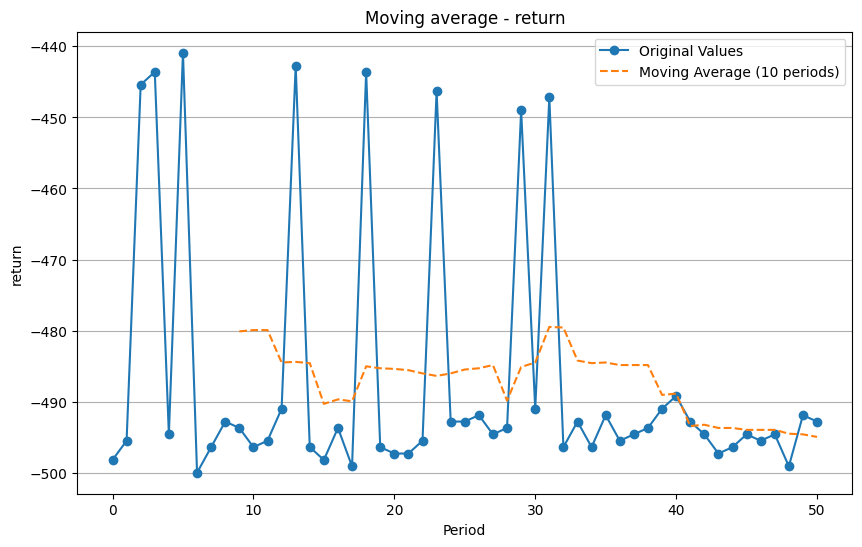

In [3]:
from resources import plot_moving_avg, plot_metric_per_iteration
plot_moving_avg('return', returns)

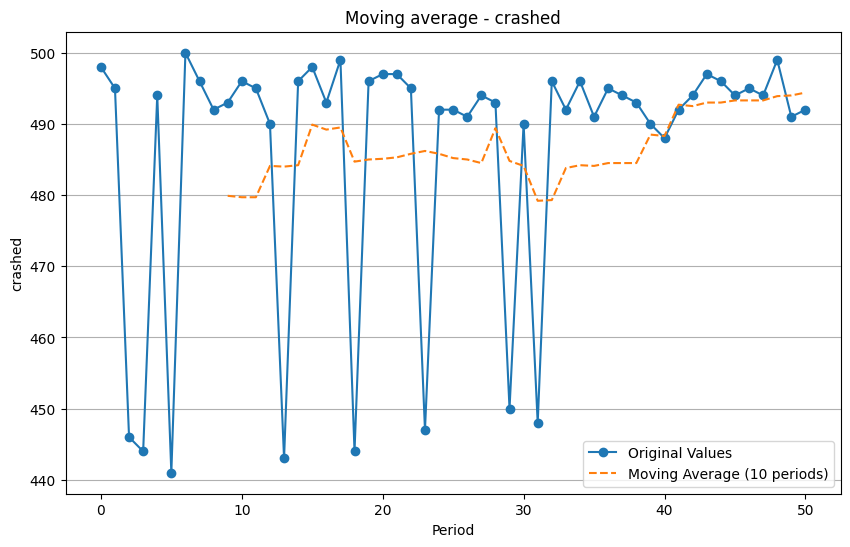

In [4]:
plot_moving_avg('crashed', crashed)

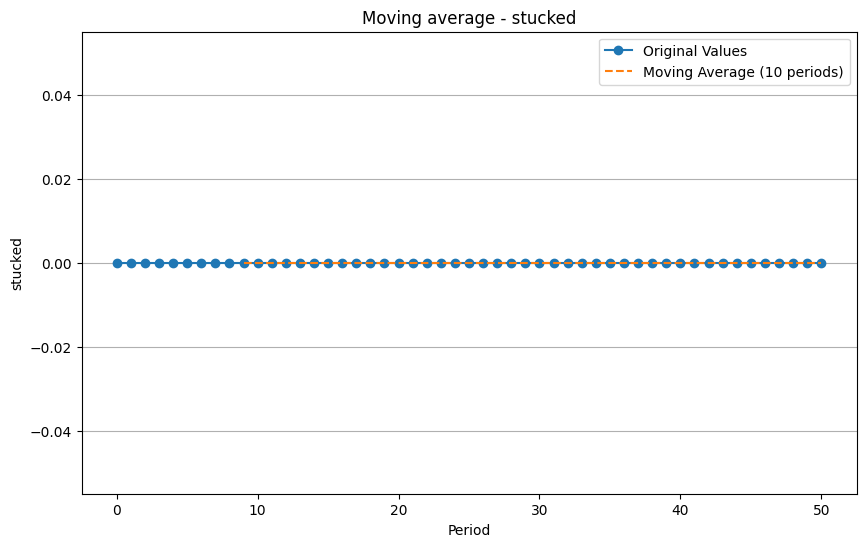

In [5]:
plot_moving_avg('stucked', stucked)

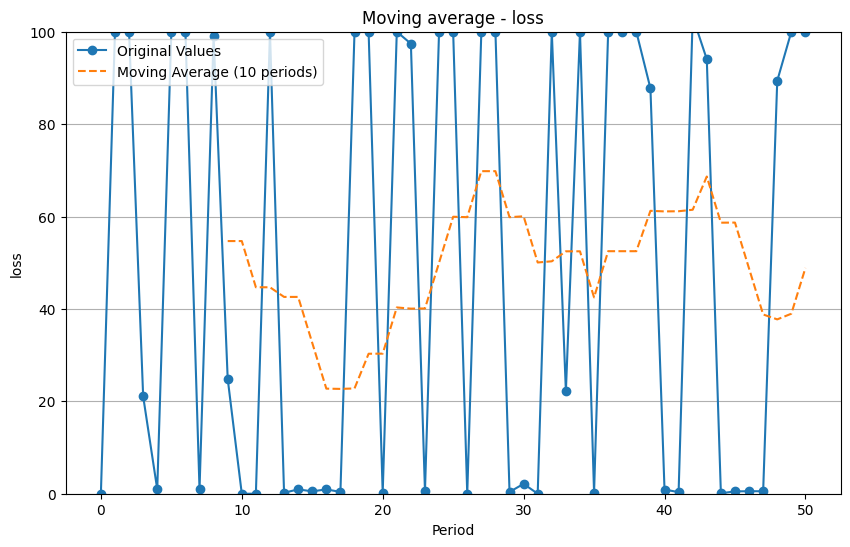

In [6]:
plot_moving_avg('loss', log_loss, ylim=True, top_lim=1_00)

In [8]:
df_log.to_csv(f"logs/02-stuck-improving/{description}_comb-{combination+1}-run-{run+1}.csv", index=None, header=True)

## Visualization

In [7]:
from resources import create_policy_eval_video


# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(1)
train_py_env.set_size(maze_size)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, f"trained-agent-{description}", train_env, train_py_env)

Mode set: 1
Maze site set: 3x3
